In [336]:
# prerequisites 
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd

In [337]:
def readDatas(dataPath: str):
    return pd.read_csv(dataPath,delimiter=',', header='infer')

In [338]:
def plotDataDistribution(df_world_happiness):
    fig,axes = plt.subplots(nrows=3,figsize=(15,15))

    axes[0].hist(df_world_happiness["Happiness.Score"])
    axes[0].set_title("Happiness")

    axes[1].hist(df_world_happiness["Economy..GDP.per.Capita."])
    axes[1].set_title("PIB")

    axes[2].hist(df_world_happiness["Freedom"])
    axes[2].set_title("Freedom")
    plt.show()

In [339]:
def plotData(df_world_happiness):
    fig = plt.figure()
    axes = fig.add_subplot(projection='3d')

    axes.scatter(df_world_happiness["Economy..GDP.per.Capita."],df_world_happiness["Freedom"],df_world_happiness["Happiness.Score"])
    axes.set_xlabel('GDP')
    axes.set_ylabel('Freedom')
    axes.set_zlabel('Happiness')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()

In [340]:
def getTrainingAndValidationSets(df_world_happiness):
    dataSize = df_world_happiness.shape[0]
    trainingIndexSet = np.random.choice(range(dataSize),size=int(0.8 * dataSize),replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet] 

    trainingInputSet = [[df_world_happiness["Economy..GDP.per.Capita."].iloc[index], df_world_happiness["Freedom"].iloc[index]] for index in trainingIndexSet ]
    trainingOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in trainingIndexSet ]

    validationInputSet = [[df_world_happiness["Economy..GDP.per.Capita."].iloc[index],df_world_happiness["Freedom"].iloc[index]] for index in validationIndexSet ]
    validationOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in validationIndexSet ]
    
    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet

def plotTrainingAndValidationDatas(df_world_happiness):
    trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet = getTrainingAndValidationSets(df_world_happiness)
    axes  = plt.figure().add_subplot(projection='3d')

    xTraining = [point[0] for point in trainingInputSet]
    yTraining = [point[1] for point in trainingInputSet]

    xValidation = [point[0] for point in validationInputSet]
    yValidation = [point[1] for point in validationInputSet]

    axes.scatter(xTraining,yTraining,trainingOutputSet)
    axes.scatter(xValidation,yValidation,validationOutputSet)
    axes.set_xlabel('GDP')
    axes.set_ylabel('Freedom')
    axes.set_zlabel('Happiness')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()

In [341]:
def getRegressor(df_world_happiness):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets(df_world_happiness)
    xx = [el for el in trainingInputSet]

    regressor = linear_model.LinearRegression()
    regressor.fit(xx, trainingOutputSet)

    return regressor

In [342]:
def plotRegressor(df_world_happiness):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets(df_world_happiness)
    trainingInputSet = np.array(trainingInputSet)  # Convert to NumPy array
    regressor = getRegressor(df_world_happiness)
    w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]
    
    # Generate data for plotting the plane
    x_min, x_max = np.min(trainingInputSet[:,0]), np.max(trainingInputSet[:,0])
    y_min, y_max = np.min(trainingInputSet[:,1]), np.max(trainingInputSet[:,1])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
    zz = w0 + w1 * xx + w2 * yy

    # Plot the data points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(trainingInputSet[:,0], trainingInputSet[:,1], trainingOutputSet, c='b', marker='o', label='Training Data')
    
    # Plot the plane representing the model
    ax.plot_surface(xx, yy, zz, alpha=0.5, cmap='viridis', label='Model Plane')
    
    ax.set_title('Training Data and Model Plane')
    ax.set_xlabel('GDP')
    ax.set_ylabel('Freedom')
    ax.set_zlabel('Happiness')
    
    plt.show()



In [343]:
from sklearn.metrics import mean_squared_error

def getErrors(df_world_happiness):
    _,_,validationInputSet, validationOutputSet = getTrainingAndValidationSets(df_world_happiness)
    regressor = getRegressor(df_world_happiness)
    computedValidationOutputs = regressor.predict([x for x in validationInputSet])
    manualError = 0.0
    for t1, t2 in zip(computedValidationOutputs, validationOutputSet):
        manualError += (t1 - t2) ** 2
    manualError = manualError / len(validationOutputSet)
    computedError = mean_squared_error(validationOutputSet, computedValidationOutputs)
    return manualError, computedError


## Problema 1

In [344]:
world_happiness_v1 = readDatas("datas/v1_world-happiness-report-2017.csv")
world_happiness_v1["Happiness.Score"] = world_happiness_v1["Happiness.Score"].fillna(world_happiness_v1["Happiness.Score"][0])
world_happiness_v1["Economy..GDP.per.Capita."] = world_happiness_v1["Economy..GDP.per.Capita."].fillna(world_happiness_v1["Economy..GDP.per.Capita."][0])
world_happiness_v1["Freedom"] = world_happiness_v1["Freedom"].fillna(world_happiness_v1["Freedom"][0])

q1= world_happiness_v1["Happiness.Score"].quantile(0.01)
q2= world_happiness_v1["Happiness.Score"].quantile(0.99)

world_happiness_v1 = world_happiness_v1[world_happiness_v1["Happiness.Score"].between(q1,q2)]

q3= world_happiness_v1["Economy..GDP.per.Capita."].quantile(0.01)
q4= world_happiness_v1["Economy..GDP.per.Capita."].quantile(0.99)

world_happiness_v1 = world_happiness_v1[world_happiness_v1["Economy..GDP.per.Capita."].between(q3,q4)]

q5= world_happiness_v1["Freedom"].quantile(0.01)
q6= world_happiness_v1["Freedom"].quantile(0.99)

world_happiness_v1 = world_happiness_v1[world_happiness_v1["Freedom"].between(q5,q6)]



# world_happiness = world_happiness.dropna()


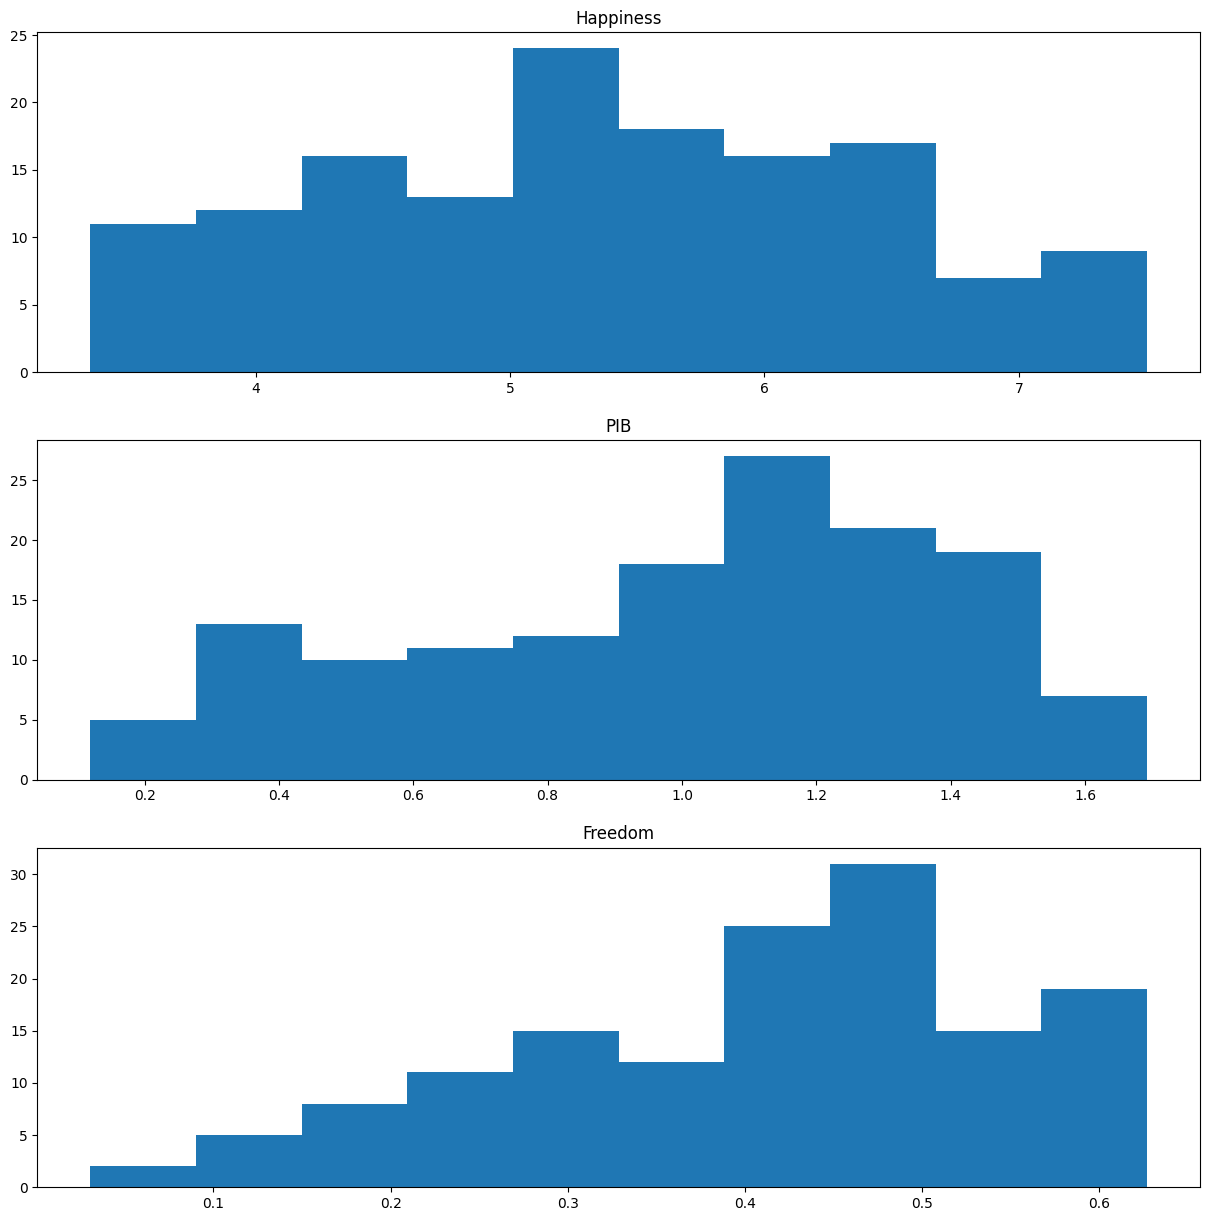

In [345]:
plotDataDistribution(world_happiness_v1)

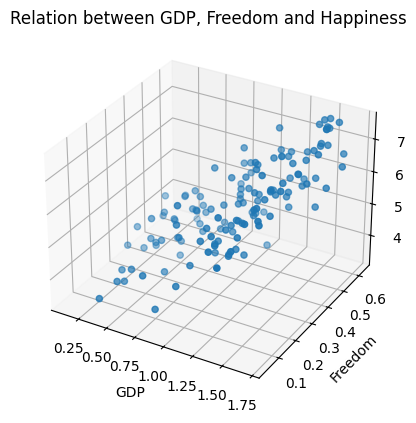

In [346]:
plotData(world_happiness_v1)

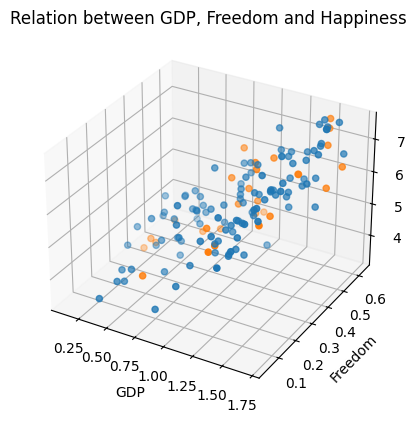

In [347]:
plotTrainingAndValidationDatas(world_happiness_v1)

In [348]:
regresor = getRegressor(world_happiness_v1)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 2.4831193134955045 + 1.883119978712206*x1 + 2.501771551225327*x2


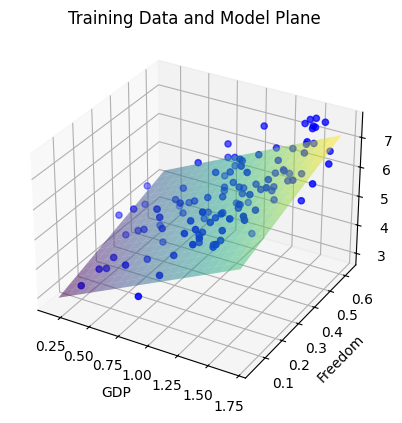

In [349]:
plotRegressor(world_happiness_v1)

In [350]:
mErr, cErr = getErrors(world_happiness_v1)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.5105055263114355
Computed error: 0.5105055263114355


## Problema 2

In [351]:
world_happiness_v2 = readDatas("datas/v1_world-happiness-report-2017.csv")
world_happiness_v2["Happiness.Score"] = world_happiness_v2["Happiness.Score"].fillna(world_happiness_v2["Happiness.Score"][0])
world_happiness_v2["Economy..GDP.per.Capita."] = world_happiness_v2["Economy..GDP.per.Capita."].fillna(world_happiness_v2["Economy..GDP.per.Capita."][0])
world_happiness_v2["Freedom"] = world_happiness_v2["Freedom"].fillna(world_happiness_v2["Freedom"][0])

q1= world_happiness_v2["Happiness.Score"].quantile(0.01)
q2= world_happiness_v2["Happiness.Score"].quantile(0.99)

world_happiness_v2 = world_happiness_v2[world_happiness_v2["Happiness.Score"].between(q1,q2)]

q3= world_happiness_v2["Economy..GDP.per.Capita."].quantile(0.01)
q4= world_happiness_v2["Economy..GDP.per.Capita."].quantile(0.99)

world_happiness_v2 = world_happiness_v2[world_happiness_v2["Economy..GDP.per.Capita."].between(q3,q4)]

q5= world_happiness_v2["Freedom"].quantile(0.01)
q6= world_happiness_v2["Freedom"].quantile(0.99)

world_happiness_v2 = world_happiness_v2[world_happiness_v2["Freedom"].between(q5,q6)]



# world_happiness = world_happiness.dropna()


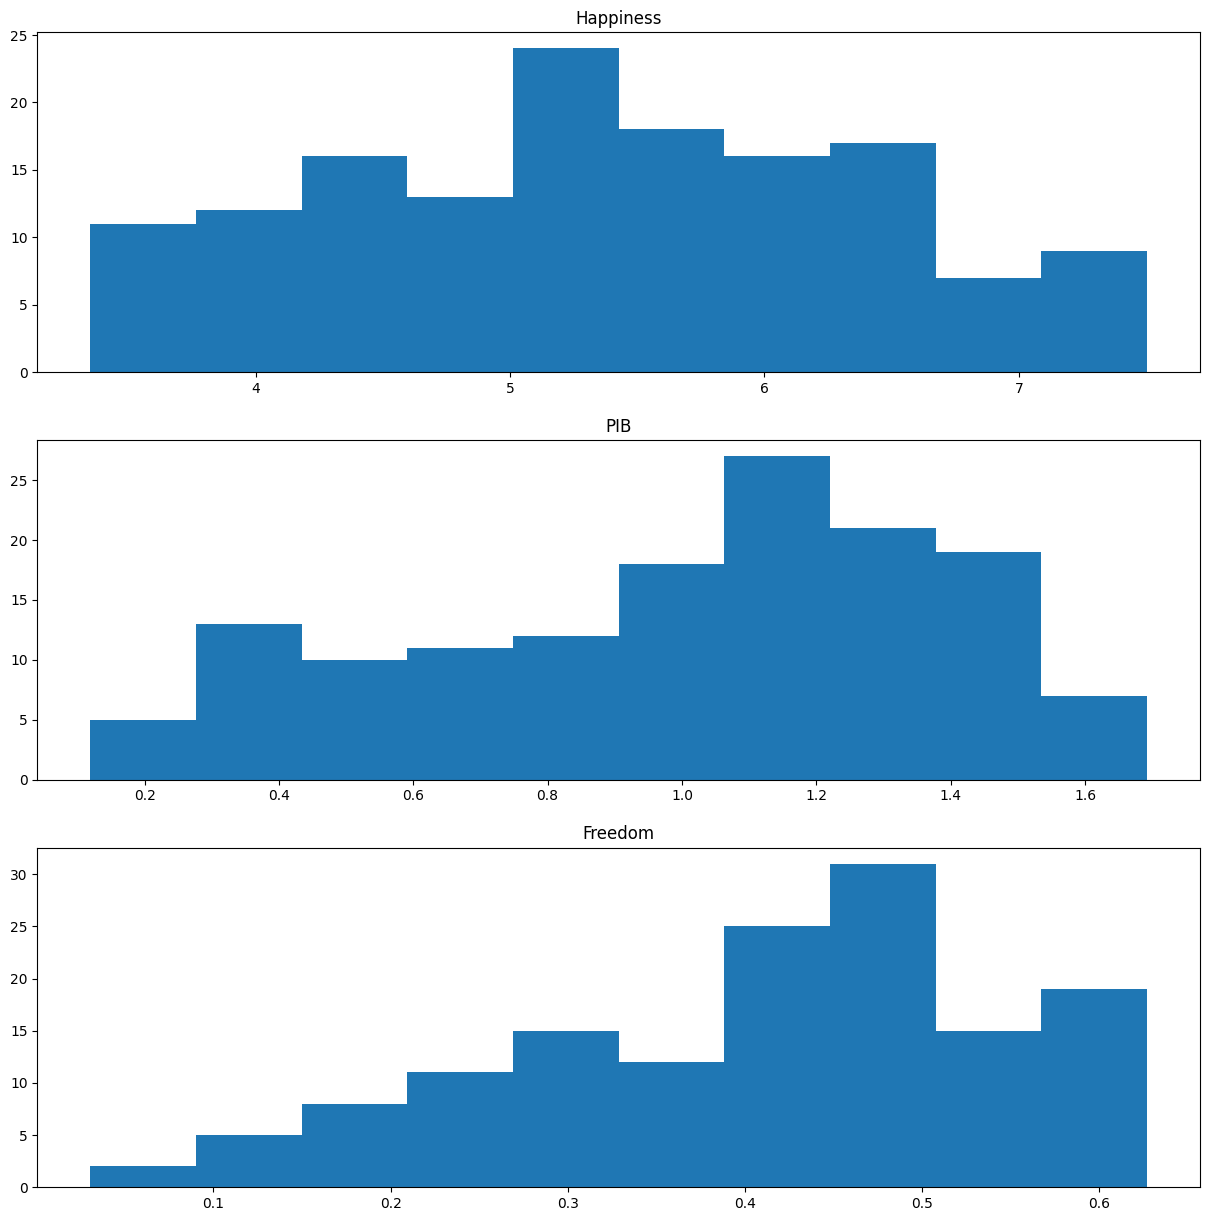

In [352]:
plotDataDistribution(world_happiness_v2)

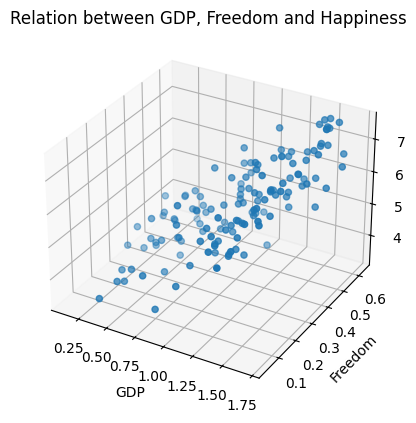

In [353]:
plotData(world_happiness_v2)

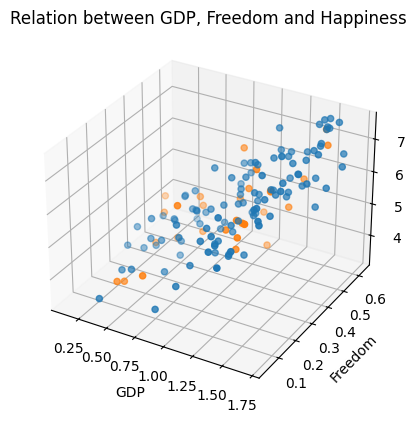

In [354]:
plotTrainingAndValidationDatas(world_happiness_v2)

In [355]:
regresor = getRegressor(world_happiness_v2)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 2.4527106294153085 + 1.9953698239011304*x1 + 2.2182575711319776*x2


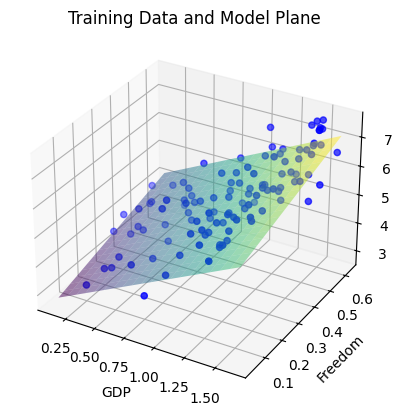

In [356]:
plotRegressor(world_happiness_v2)

In [357]:
mErr, cErr = getErrors(world_happiness_v2)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.4126192927158417
Computed error: 0.4126192927158417


## Problema 3

In [358]:
world_happiness_v3 = readDatas("datas/v1_world-happiness-report-2017.csv")
world_happiness_v3["Happiness.Score"] = world_happiness_v3["Happiness.Score"].fillna(world_happiness_v3["Happiness.Score"][0])
world_happiness_v3["Economy..GDP.per.Capita."] = world_happiness_v3["Economy..GDP.per.Capita."].fillna(world_happiness_v3["Economy..GDP.per.Capita."][0])
world_happiness_v3["Freedom"] = world_happiness_v3["Freedom"].fillna(world_happiness_v3["Freedom"][0])

q1= world_happiness_v3["Happiness.Score"].quantile(0.01)
q2= world_happiness_v3["Happiness.Score"].quantile(0.99)

world_happiness_v3 = world_happiness_v3[world_happiness_v3["Happiness.Score"].between(q1,q2)]

q3= world_happiness_v3["Economy..GDP.per.Capita."].quantile(0.01)
q4= world_happiness_v3["Economy..GDP.per.Capita."].quantile(0.99)

world_happiness_v3 = world_happiness_v2[world_happiness_v3["Economy..GDP.per.Capita."].between(q3,q4)]

q5= world_happiness_v3["Freedom"].quantile(0.01)
q6= world_happiness_v3["Freedom"].quantile(0.99)

world_happiness_v3 = world_happiness_v3[world_happiness_v3["Freedom"].between(q5,q6)]



# world_happiness = world_happiness.dropna()


/tmp/ipykernel_1652/3115358263.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  world_happiness_v3 = world_happiness_v2[world_happiness_v3["Economy..GDP.per.Capita."].between(q3,q4)]


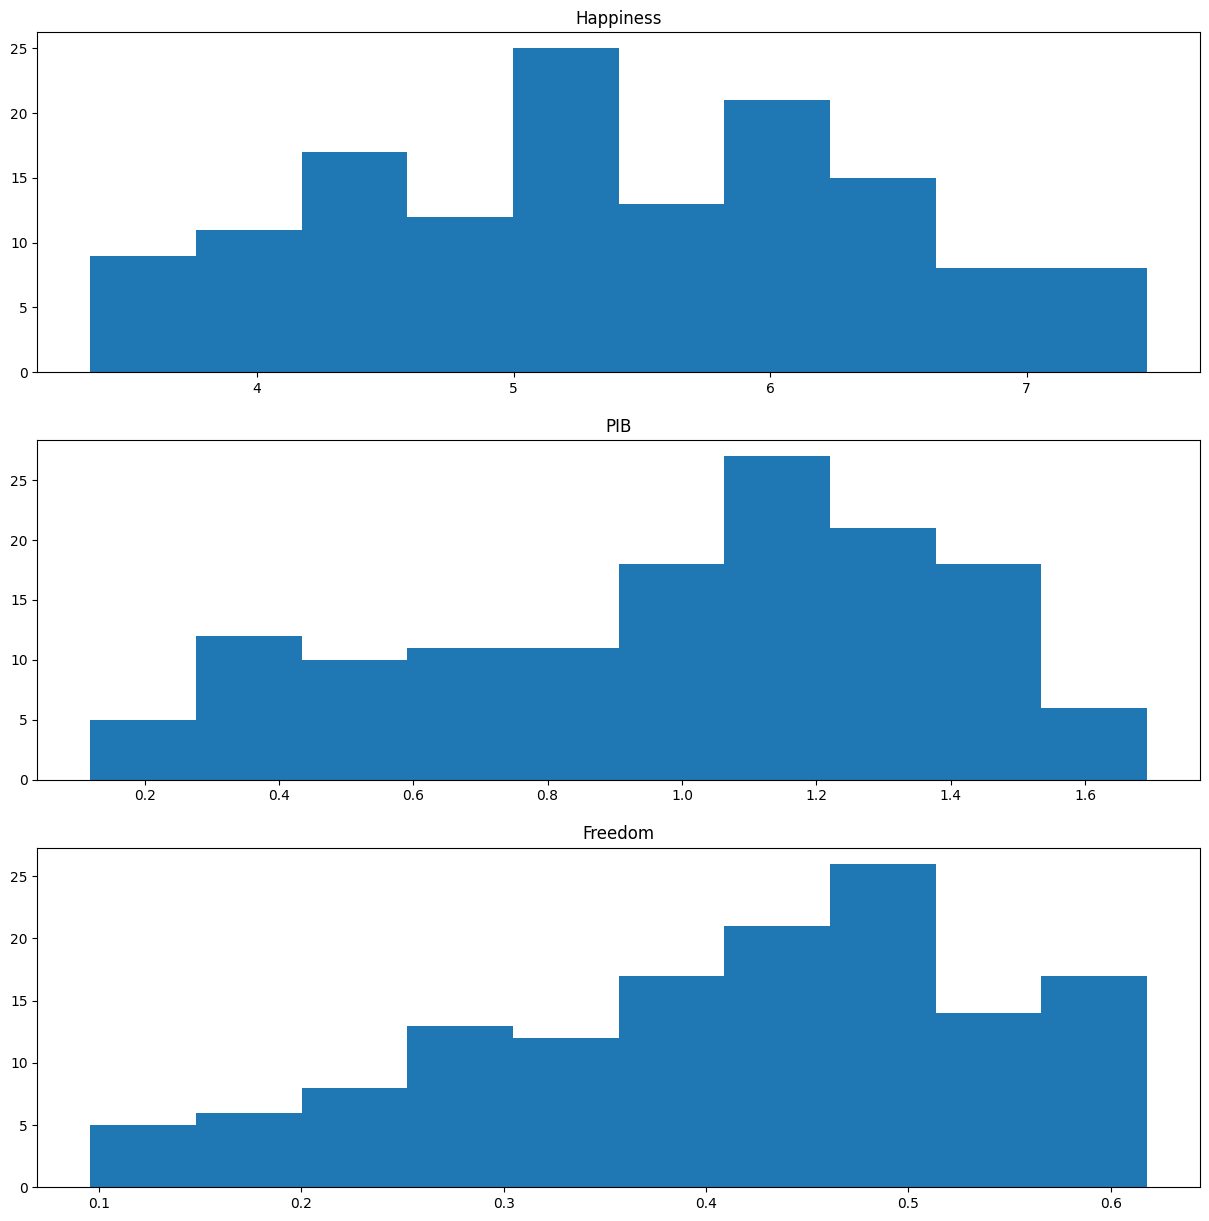

In [359]:
plotDataDistribution(world_happiness_v3)

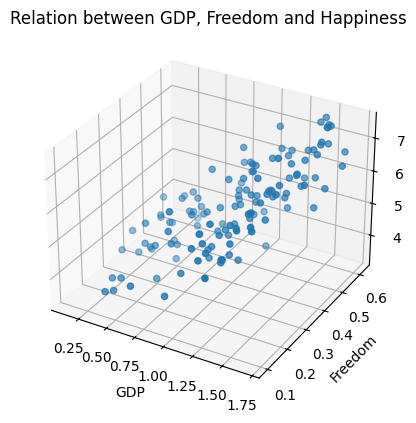

In [360]:
plotData(world_happiness_v3)

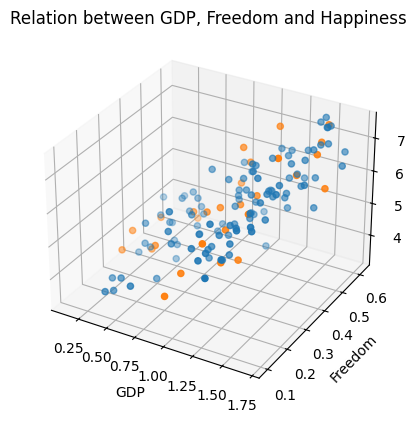

In [361]:
plotTrainingAndValidationDatas(world_happiness_v3)

In [362]:
regresor = getRegressor(world_happiness_v3)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 2.50803884274086 + 2.0339548996785712*x1 + 1.925421484181564*x2


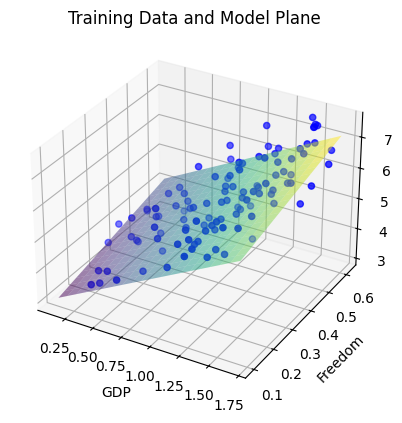

In [363]:
plotRegressor(world_happiness_v3)

In [364]:
mErr, cErr = getErrors(world_happiness_v3)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.2979253236501075
Computed error: 0.2979253236501075
